In [1]:
import numpy as np
from matplotlib import pyplot as plt
import importlib
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import fermi_surface as fs
importlib.reload(fs)
import density_of_states as dos
importlib.reload(dos);

### Coefficientfunctions
Define a couple functions for the coefficients for the tests.

In [2]:
def f_i_linear(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    return k[..., i-1]

def df_i_linear(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., i-1] = 1.0
    return d

def ddf_i_linear(k, i):
    return np.zeros(np.shape(k) + (np.shape(k)[-1],))

def f_i_exp(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    if i % 2 == 1:
        return np.cos(k[..., (i-1)//2])
    else:
        return np.sin(k[..., (i-1)//2])

def df_i_exp(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.sin(k[..., (i-1)//2])[:,None] * d
    else:
        return np.cos(k[..., (i-1)//2])[:,None] * d

def ddf_i_exp(k, i):
    assert i >= 0
    d = np.zeros(np.shape(k) + (np.shape(k)[-1],))
    if i == 0:
        return d
    d[..., (i-1)//2, (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.cos(k[..., (i-1)//2])[:,None,None] * d
    else:
        return -np.sin(k[..., (i-1)//2])[:,None,None] * d

# Tests

[[[-1.838+0.j    -0.   -0.j   ]
  [-0.   +0.j     0.941+0.j   ]]

 [[-0.494-0.j     0.569+0.j   ]
  [ 0.569-0.j    -1.841+0.j   ]]

 [[-0.194+0.j    -1.379+0.409j]
  [-1.379-0.409j -0.06 +0.j   ]]]
loss: 2.90e-01
loss: 7.37e-01
loss: 1.46e-01
loss: 1.19e-01
loss: 7.26e-01
loss: 1.50e-01
loss: 1.18e-01
loss: 7.26e-01
loss: 1.50e-01
loss: 1.18e-01
final loss: 0.11784181222661032
[[[-1.303+0.j -0.   -0.j]
  [ 0.   -0.j  0.406-0.j]]

 [[-1.753+0.j  0.   -0.j]
  [ 0.   -0.j -0.581-0.j]]

 [[-0.464+0.j  0.   -0.j]
  [ 0.   +0.j  0.21 +0.j]]]


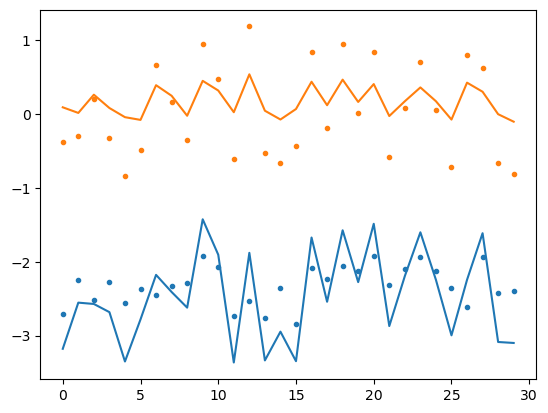

In [3]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])
tb2_ref.normalize()
print(tb2_ref.params)

#k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)
k_smpl = np.random.random((30, 2))

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

In [4]:
# test gradients
tb2 = BandStructureModel(f_i_exp, df_i_exp,
                        [random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6)], ddf_i_exp)
tb2.normalize()

h = 1e-6
k_smpl = np.random.random((30, 3))
dx = np.reshape((h, 0, 0), (1, -1))
dy = np.reshape((0, h, 0), (1, -1))
dz = np.reshape((0, 0, h), (1, -1))

# test gradients
bands, grads = tb2.bands_grad(k_smpl)
bandsx = tb2.bands(k_smpl + dx)
bandsy = tb2.bands(k_smpl + dy)
bandsz = tb2.bands(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(bands + (grads * dx.reshape(1,-1,1)).sum(1) - bandsx) / h**2)
print(np.linalg.norm(bands + (grads * dy.reshape(1,-1,1)).sum(1) - bandsy) / h**2)
print(np.linalg.norm(bands + (grads * dz.reshape(1,-1,1)).sum(1) - bandsz) / h**2)

# test hessians
k_smpl = np.random.random((30, 3))
bands, grads, hess = tb2.bands_grad_hess(k_smpl)
#print(np.linalg.norm(hess, axis=(0, -1)))
bandsx, gradsx = tb2.bands_grad(k_smpl + dx)
bandsy, gradsy = tb2.bands_grad(k_smpl + dy)
bandsz, gradsz = tb2.bands_grad(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(grads + hess[:,:,0]*h - gradsx, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,1]*h - gradsy, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,2]*h - gradsz, axis=(0,2)) / h**2)


13.841868322551031
10.42146048130361
6.965851156003502
[44.677 16.57  14.479]
[14.611 31.307  9.558]
[16.491  9.663 26.9  ]


[[[-2.281+0.j     0.   +0.j     0.   +0.j   ]
  [ 0.   -0.j    -0.049+0.j    -0.   +0.j   ]
  [ 0.   +0.j    -0.   +0.j     2.544+0.j   ]]

 [[-0.938-0.j     0.2  +0.j     2.309-0.084j]
  [ 0.2  +0.j     0.395+0.j     2.046+0.j   ]
  [ 2.309+0.084j  2.046-0.j    -0.121+0.j   ]]]
loss: 2.83e-01
loss: 5.81e-02
loss: 1.99e-03
loss: 2.99e-04
loss: 1.99e-05
loss: 1.49e-06
loss: 1.38e-07
loss: 6.39e-09
loss: 9.71e-10
loss: 1.62e-11
final loss: 3.695922377533084e-12
[[[-2.281-0.j     0.   -0.j    -0.   -0.j   ]
  [ 0.   +0.j    -0.049+0.j     0.   -0.j   ]
  [-0.   +0.j    -0.   -0.j     2.544+0.j   ]]

 [[-0.938+0.j     0.236-0.j     1.921-1.269j]
  [ 0.236+0.j     0.395+0.j     2.05 +0.j   ]
  [ 1.921+1.269j  2.05 +0.j    -0.121-0.j   ]]]


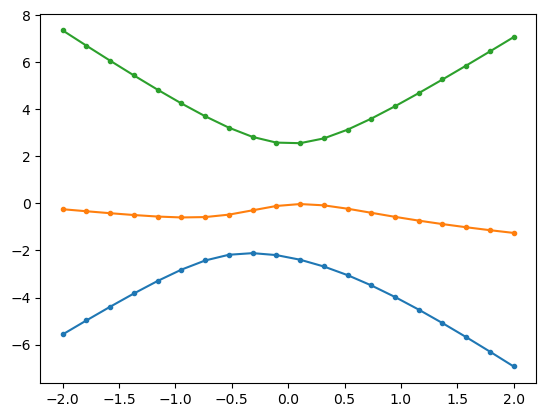

In [5]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])
tb2_ref.normalize()
print(tb2_ref.params)

k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

# Real Data

For real data, use a tight binding model with just $\cos$ terms. The Hamilton operator of this model has only s symmetry orbitals. These orbitals can be located at any high symmtry point. Together they can form the orbitals that have a different symmetry.

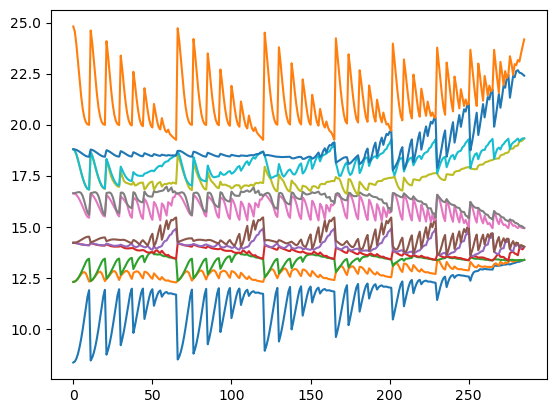

In [6]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_weights, ref_bands, symmetries, fermi_energy = material.read_bands()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
plot_bands_generic(k_smpl, ref_bands, '-')

loss: 7.37e-02
loss: 3.76e-02
loss: 2.89e-02
loss: 1.88e-02
loss: 1.21e-02
loss: 1.35e-02
loss: 1.43e-02
loss: 9.96e-03
loss: 1.24e-02
loss: 9.14e-03
loss: 8.46e-03
loss: 7.74e-03
loss: 6.97e-03
loss: 5.93e-03
loss: 6.11e-03
loss: 5.15e-03
loss: 4.69e-03
loss: 4.28e-03
loss: 4.21e-03
loss: 4.47e-03


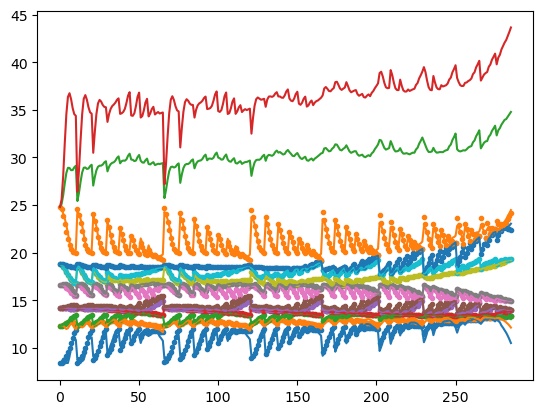

In [7]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_weights, ref_bands, symmetries, fermi_energy = material.read_bands()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]

# now start my algorithm to find good matrices
additional_bands = 2
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.005
weights[1] = 0.005
weights[2] = 0.05
weights[3] = 0.5
weights[-1] = 0.005
weights[-2] = 0.05
weights[-3] = 0.5

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (2, 2, 2), (3, 0, 0)) # works well
tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.cubic(True), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=True)
tb_nitinol.normalize()
tb_nitinol.optimize(k_smpl, ref_weights, ref_bands, weights, band_offset, 2000, 4, train_k0=False)

plot_bands_generic(k_smpl, ref_bands, '.')
tb_nitinol.plot_bands(k_smpl)

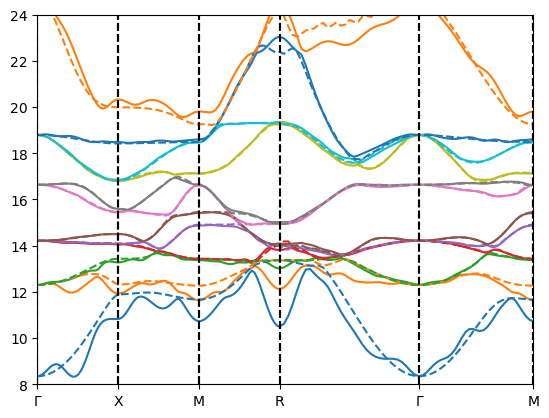

In [8]:
import kpaths
path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.cubic(True), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

In [9]:
bands_map = { tuple(np.round(k, 4)): np.round(bands, 4)  for k, bands in zip(k_smpl, all_ref_bands)}
print(bands_map.keys())
bands = bands_map[(-0.5,-0.5,-0.5)]
#bands = bands_map[(0,0,0)]
print(bands)
# count degeneracies
unique = set(bands)
print("unique values:", len(unique))
print("1-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 1]))
print("2-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 2]))
print("3-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 3]))

dict_keys([(0.0, 0.0, 0.0), (0.0, 0.0, 0.05), (0.0, 0.0, 0.1), (0.0, 0.0, 0.15), (0.0, 0.0, 0.2), (0.0, 0.0, 0.25), (0.0, 0.0, 0.3), (0.0, 0.0, 0.35), (0.0, 0.0, 0.4), (0.0, 0.0, 0.45), (0.0, 0.0, -0.5), (0.0, 0.05, 0.05), (0.0, 0.05, 0.1), (0.0, 0.05, 0.15), (0.0, 0.05, 0.2), (0.0, 0.05, 0.25), (0.0, 0.05, 0.3), (0.0, 0.05, 0.35), (0.0, 0.05, 0.4), (0.0, 0.05, 0.45), (0.0, 0.05, -0.5), (0.0, 0.1, 0.1), (0.0, 0.1, 0.15), (0.0, 0.1, 0.2), (0.0, 0.1, 0.25), (0.0, 0.1, 0.3), (0.0, 0.1, 0.35), (0.0, 0.1, 0.4), (0.0, 0.1, 0.45), (0.0, 0.1, -0.5), (0.0, 0.15, 0.15), (0.0, 0.15, 0.2), (0.0, 0.15, 0.25), (0.0, 0.15, 0.3), (0.0, 0.15, 0.35), (0.0, 0.15, 0.4), (0.0, 0.15, 0.45), (0.0, 0.15, -0.5), (0.0, 0.2, 0.2), (0.0, 0.2, 0.25), (0.0, 0.2, 0.3), (0.0, 0.2, 0.35), (0.0, 0.2, 0.4), (0.0, 0.2, 0.45), (0.0, 0.2, -0.5), (0.0, 0.25, 0.25), (0.0, 0.25, 0.3), (0.0, 0.25, 0.35), (0.0, 0.25, 0.4), (0.0, 0.25, 0.45), (0.0, 0.25, -0.5), (0.0, 0.3, 0.3), (0.0, 0.3, 0.35), (0.0, 0.3, 0.4), (0.0, 0.3, 0.45)

In [17]:
for i, (r, mat) in enumerate(zip(neighbors + neighbors, tb_nitinol.params)):
    print(r, np.linalg.norm(mat), "real" if np.linalg.norm(np.imag(mat)) < 1e-8 else "complex")

(0, 0, 0) 66.61267243086847 real
(1, 0, 0) 0.5260028610868768 complex
(1, 1, 0) 0.4456820502214223 complex
(1, 1, 1) 0.3089457313021553 complex
(2, 0, 0) 0.2740217698421757 complex
(2, 1, 0) 0.29875677389868094 complex
(2, 1, 1) 0.26887238662245 complex
(2, 2, 1) 0.22800085626909164 complex
(2, 2, 2) 0.19183093505832366 complex
(3, 0, 0) 0.2291010900102371 complex


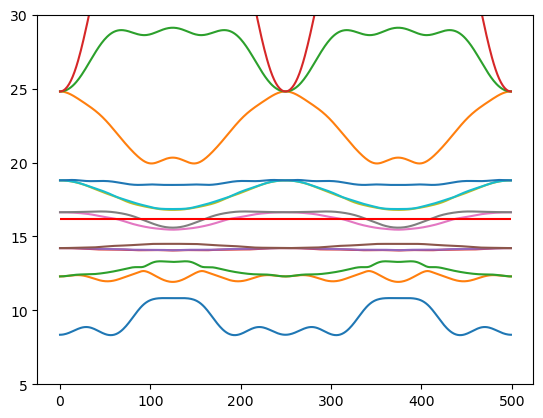

In [11]:
fermi_energy = 16.157
k_smpl = np.linspace(0, 2, 500).reshape(-1, 1) * [[1, 0, 0]]
tb_nitinol.plot_bands(k_smpl)
plt.hlines(fermi_energy, 0, len(k_smpl)-1, 'r')
plt.ylim(5, 30)
plt.show()

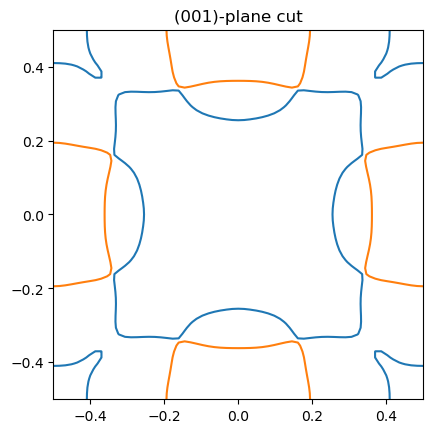

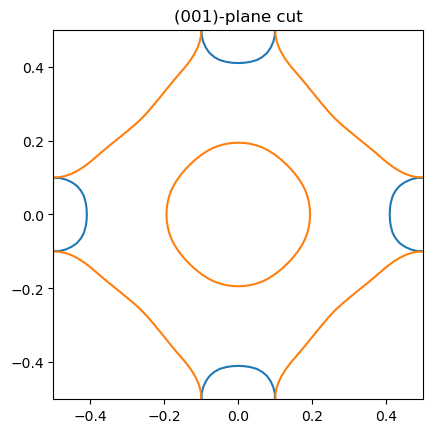

In [12]:
importlib.reload(fs)
fermi_energy = 16.157
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

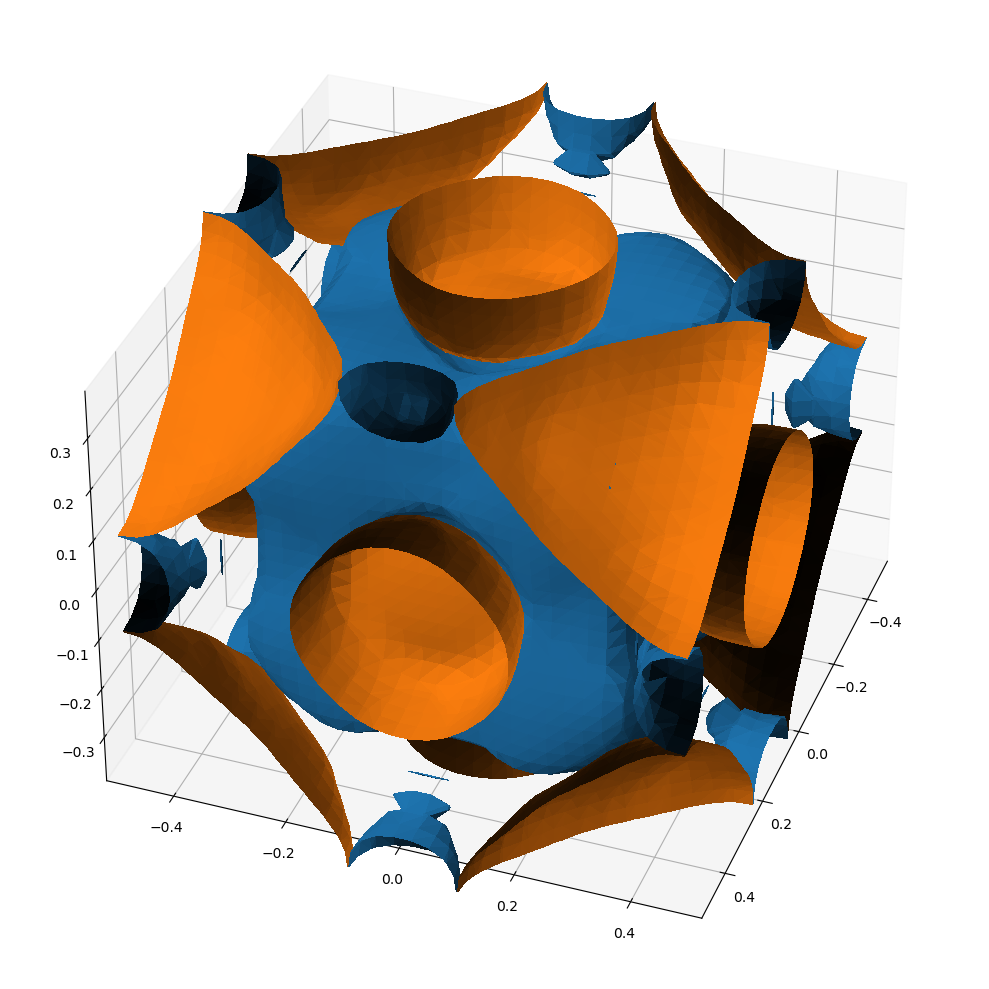

In [13]:
importlib.reload(fs)
# plot the fermi surface
fermi_energy = 16.157
fs.plot_3D_fermi_surface(tb_nitinol, fermi_energy, N=32)

In [14]:
# calculate conductivity (Czycholl page 269)
tau = 1e-15 # in s
elementary_charge = 1.602176634e-19 # in Coulomb
eV = elementary_charge # 1 eV in Joule
fermi_energy = 16.157 # in eV
T = 300
kB = 8.61733326214518e-5 # in eV/K
beta = 1 / (kB * T) # in 1/eV
alat = 2.993e-10 # m
hbar = 1.05457181764616e-34 # in SI J*s
k_unit = np.pi/2/alat # 1/m
def fermi(x):
    #return 1 / (1 + np.exp(x))
    return (np.tanh(-0.5 * x) + 1) * 0.5
def dfermi(x): # ~ exp(-x*x/5)/4
    #e = np.exp(x)
    #return -1 / (e + 2 + 1/e)
    return -0.25 / np.cosh(0.5 * x)**2
N = 20
k_smpl = np.meshgrid(np.linspace(0, 1, N, endpoint=False), np.linspace(0, 1, N, endpoint=False), np.linspace(0, 1, N, endpoint=False))
k_smpl += np.random.random(np.shape(k_smpl)) * ((1 - 0) / N) # this improves the integral a lot because it breaks symmetry -> *len(sym_group) integration sites
k_smpl = np.stack(k_smpl, axis=-1).reshape(-1, 3)
bands, grads = tb_nitinol.bands_grad(k_smpl)
v = grads * (eV / k_unit / hbar) # in m/s
#print(np.mean(np.mean(np.abs(v), axis=0), axis=1))
#print(np.mean(v)/np.mean(np.abs(v))) # this should be 0 for perfect sampling
# simplest integral formula
data = np.einsum("iaj,ibj,ij->iab", v, v, -dfermi((bands - fermi_energy) * beta))
I = np.mean(data, axis=0) # result is m^2/s^2
err = np.std(data, axis=0) / len(data)**0.5
sigma = 2 * elementary_charge**2 * tau * (beta*I)/eV / alat**3 # result is in 1/(Ohm*m)
avg_sigma = np.trace(sigma)/3
print(f"{sigma/avg_sigma}*{avg_sigma:.3e}\nwith error\n{err/np.abs(I)*100}%")

[[ 1.03   0.017 -0.004]
 [ 0.017  1.012 -0.005]
 [-0.004 -0.005  0.958]]*1.132e+07
with error
[[  4.224 107.877 455.355]
 [107.877   4.059 386.636]
 [455.355 386.636   3.907]]%


/tmp/ipykernel_250464/2492184768.py:18: RuntimeWarning: overflow encountered in square
  return -0.25 / np.cosh(0.5 * x)**2


In [15]:
sigma_ref = 1 / 8.2e-8 # 1/(Ohm*m) Austenit (sc)
print(f"{sigma_ref:.2e}")
sigma_ref = 1 / 7.6e-8 # 1/(Ohm*m) Martensite
print(f"{sigma_ref:.2e}")

1.22e+07
1.32e+07
